# KorChatbot Dataset EDA

## 데이터 및 패키지 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')


# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

In [2]:
csvdataset = pd.read_csv("kor_chatbot.csv")
csvdataset

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
# check null

csvdataset.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [4]:
# 필요 패키지

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from kogpt2_transformers import get_kogpt2_tokenizer
from kobert_transformers import get_tokenizer

from transformers import AutoTokenizer


class ChatbotDataset(Dataset):
    def __init__(self, path: str):
        self.data = pd.read_csv(path)
        self.tokenizer = get_kogpt2_tokenizer

    def __len__(self):
        return len(self.data["label"])

    def __getitem__(self, idx: int) -> tuple:
        return (self.data["Q"][idx], self.data["A"][idx], self.data["label"][idx])

## 전처리

In [6]:
# EDA preprocessing

dataset = ChatbotDataset("kor_chatbot.csv")
dl = DataLoader(dataset, shuffle=True)
kogpt2_tokenizer = get_kogpt2_tokenizer()
kobert_tokenizer = get_tokenizer()

kogpt2_tok_lens_q, kogpt2_tok_lens_a = [], []
kobert_tok_lens_q, kobert_tok_lens_a = [], []
kogpt2_toks_q, kogpt2_toks_a = [], []
kobert_toks_q, kobert_toks_a = [], []
labels = []
for (q, a, label) in dl:
    kogpt2_tok_lens_q.append(len(kogpt2_tokenizer.tokenize(q[0])))
    kogpt2_tok_lens_a.append(len(kogpt2_tokenizer.tokenize(a[0])))
    kobert_tok_lens_q.append(len(kobert_tokenizer.tokenize(q[0])))
    kobert_tok_lens_a.append(len(kobert_tokenizer.tokenize(a[0])))
    labels.append(label)
    kogpt2_toks_q.extend(kogpt2_tokenizer.tokenize(q[0]))
    kogpt2_toks_a.extend(kogpt2_tokenizer.tokenize(a[0]))
    kobert_toks_q.extend(kobert_tokenizer.tokenize(q[0]))
    kobert_toks_a.extend(kobert_tokenizer.tokenize(a[0]))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [7]:
print("KoGPT2 Question 전체 토큰 수", len(set(kogpt2_toks_q)))
print("KoGPT2 Question 토큰 수 평균", np.mean(kogpt2_tok_lens_q))
print("KoGPT2 Answer 전체 토큰 수", len(set(kogpt2_toks_a)))
print("KoGPT2 Answer 토큰 수 평균", np.mean(kogpt2_tok_lens_a))

print("KoBERT Question 전체 토큰 수", len(set(kobert_toks_q)))
print("KoBERT Question 토큰 수 평균", np.mean(kobert_tok_lens_q))
print("KoBERT Answer 전체 토큰 수", len(set(kobert_toks_a)))
print("KoBERT Answer 토큰 수 평균", np.mean(kobert_tok_lens_a))

KoGPT2 Question 전체 토큰 수 6903
KoGPT2 Question 토큰 수 평균 6.08314302630466
KoGPT2 Answer 전체 토큰 수 5861
KoGPT2 Answer 토큰 수 평균 6.8841241647635965
KoBERT Question 전체 토큰 수 3330
KoBERT Question 토큰 수 평균 7.877103949928106
KoBERT Answer 전체 토큰 수 2884
KoBERT Answer 토큰 수 평균 9.236319039160957


## Question / Answer 토큰 빈도 분석

Text(0, 0.5, '빈도')

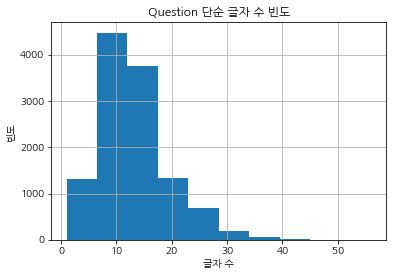

In [8]:
ax = csvdataset["Q"].str.len().hist()
ax.set_title("Question 단순 글자 수 빈도")
ax.set_xlabel("글자 수")
ax.set_ylabel("빈도")

Text(0, 0.5, '빈도')

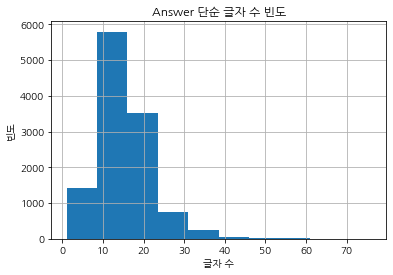

In [9]:
ax = csvdataset["A"].str.len().hist()
ax.set_title("Answer 단순 글자 수 빈도")
ax.set_xlabel("글자 수")
ax.set_ylabel("빈도")

Text(0, 0.5, '빈도')

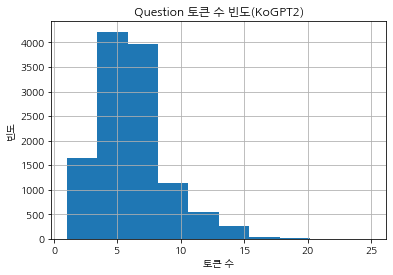

In [10]:
ax = pd.Series(kogpt2_tok_lens_q).hist()
ax.set_title("Question 토큰 수 빈도(KoGPT2)")
ax.set_xlabel("토큰 수")
ax.set_ylabel("빈도")

Text(0, 0.5, '빈도')

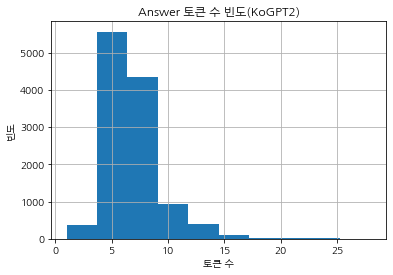

In [11]:
ax = pd.Series(kogpt2_tok_lens_a).hist()
ax.set_title("Answer 토큰 수 빈도(KoGPT2)")
ax.set_xlabel("토큰 수")
ax.set_ylabel("빈도")

Text(0, 0.5, '빈도')

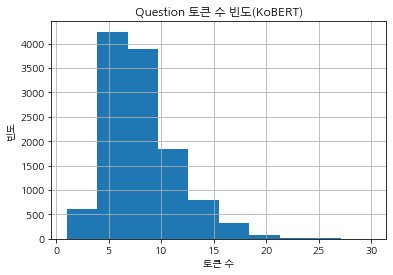

In [12]:
ax = pd.Series(kobert_tok_lens_q).hist()
ax.set_title("Question 토큰 수 빈도(KoBERT)")
ax.set_xlabel("토큰 수")
ax.set_ylabel("빈도")

Text(0, 0.5, '빈도')

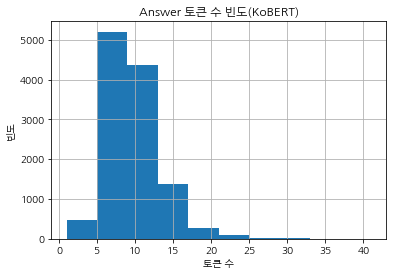

In [13]:
ax = pd.Series(kobert_tok_lens_a).hist()
ax.set_title("Answer 토큰 수 빈도(KoBERT)")
ax.set_xlabel("토큰 수")
ax.set_ylabel("빈도")

## Question / Answer 명사 빈도 분석

In [18]:
from konlpy.tag import Mecab
import collections

mecab = Mecab()

In [27]:
q_noun, a_noun = [], []
for (q, a, label) in dl:
    q_noun += mecab.nouns(q[0])
    a_noun += mecab.nouns(a[0])

q_count = collections.Counter(q_noun)
q_most = q_count.most_common()
a_count = collections.Counter(a_noun)
a_most = a_count.most_common()

q_noun2, a_noun2 = [], []
for (q, a, label) in dl:
    for n in mecab.nouns(q[0]):
        if len(n) > 1:
            q_noun2.append(n)
    for m in mecab.nouns(a[0]):
        if len(m) > 1:
            a_noun2.append(m)

q_count2 = collections.Counter(q_noun2)
q_most2 = q_count2.most_common()
a_count2 = collections.Counter(a_noun2)
a_most2 = a_count2.most_common()

[Text(0.5, 0, '빈도 수'), Text(0, 0.5, '명사')]

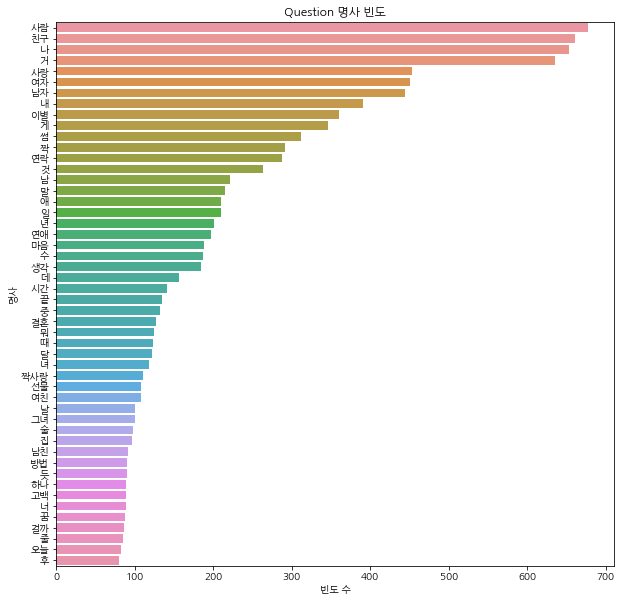

In [25]:
x, y = [], []
for word, count in q_most[:50]:
    x.append(word)
    y.append(count)
    
plt.figure(figsize=(10,10))
plt.title("Question 명사 빈도")
ax = sns.barplot(x=y, y=x)
ax.set(xlabel = '빈도 수', ylabel = '명사')

[Text(0.5, 0, '빈도 수'), Text(0, 0.5, '명사')]

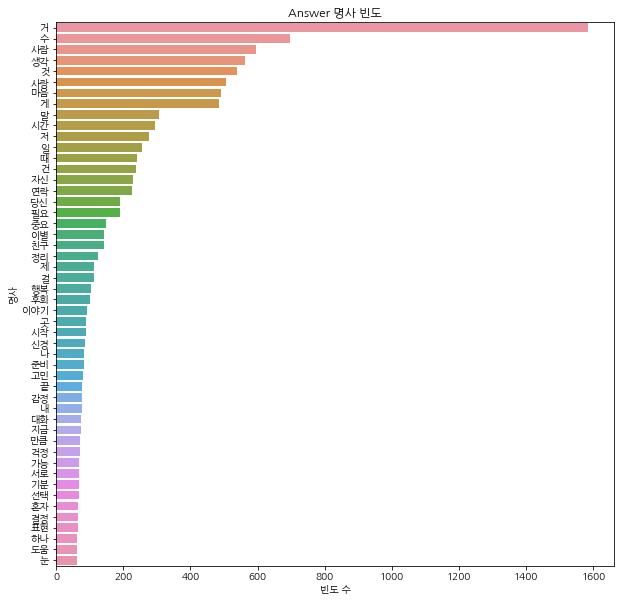

In [29]:
x, y = [], []
for word, count in a_most[:50]:
    x.append(word)
    y.append(count)
    
plt.figure(figsize=(10,10))
plt.title("Answer 명사 빈도")
ax = sns.barplot(x=y, y=x)
ax.set(xlabel = '빈도 수', ylabel = '명사')

### 2글자 이상 명사

[Text(0.5, 0, '빈도 수'), Text(0, 0.5, '명사')]

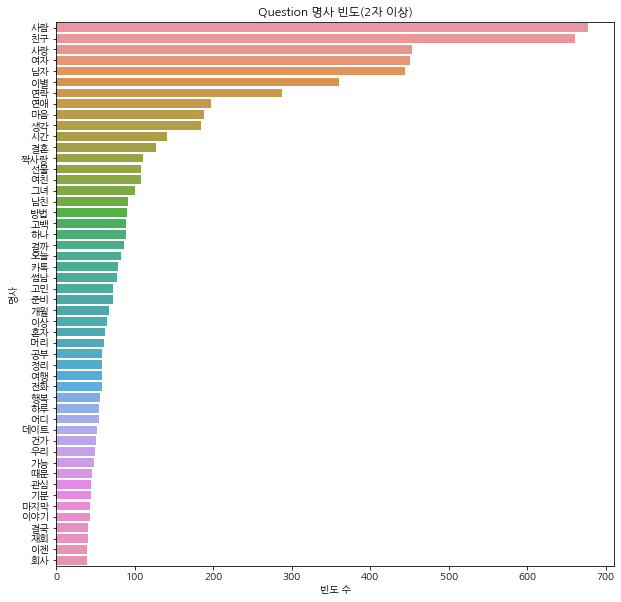

In [30]:
x, y = [], []
for word, count in q_most2[:50]:
    x.append(word)
    y.append(count)
    
plt.figure(figsize=(10,10))
plt.title("Question 명사 빈도(2자 이상)")
ax = sns.barplot(x=y, y=x)
ax.set(xlabel = '빈도 수', ylabel = '명사')

[Text(0.5, 0, '빈도 수'), Text(0, 0.5, '명사')]

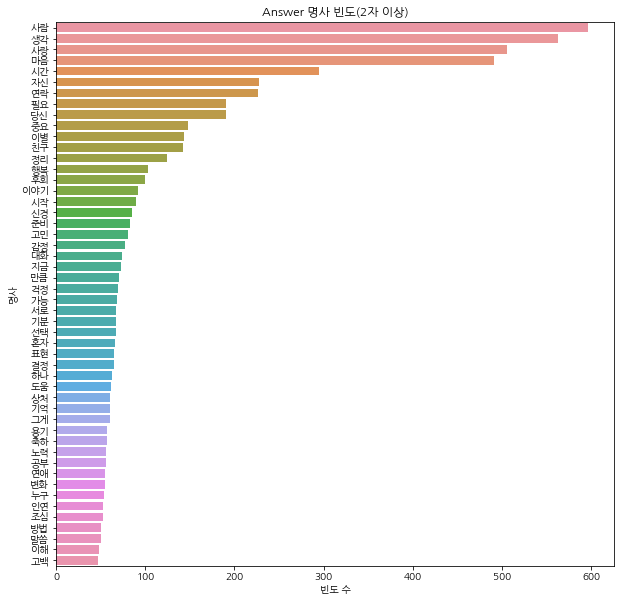

In [31]:
x, y = [], []
for word, count in a_most2[:50]:
    x.append(word)
    y.append(count)
    
plt.figure(figsize=(10,10))
plt.title("Answer 명사 빈도(2자 이상)")
ax = sns.barplot(x=y, y=x)
ax.set(xlabel = '빈도 수', ylabel = '명사')

## Question / Answer 형태소 빈도

In [54]:
q_tags, a_tags = [], []
for (q, a, label) in dl:
    q_temp = mecab.pos(q[0])
    a_temp = mecab.pos(a[0])
    for q2 in q_temp:
        q_tags.append(q2[1])
    for a2 in a_temp:
        a_tags.append(a2[1])

q_count3 = collections.Counter(q_tags)
a_count3 = collections.Counter(a_tags)

[Text(0.5, 1.0, 'Question 형태소 빈도'), Text(0.5, 0, '빈도 수'), Text(0, 0.5, '형태소')]

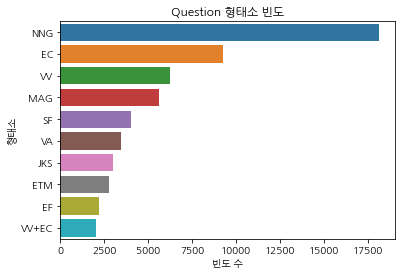

In [56]:
x, y = list(map(list, zip(*q_count3.most_common(10))))
ax = sns.barplot(x=y, y=x)
ax.set(title = 'Question 형태소 빈도', xlabel = '빈도 수', ylabel = '형태소')

[Text(0.5, 1.0, 'Answer 형태소 빈도'), Text(0.5, 0, '빈도 수'), Text(0, 0.5, '형태소')]

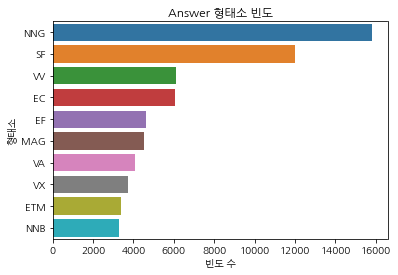

In [57]:
x, y = list(map(list, zip(*a_count3.most_common(10))))
ax = sns.barplot(x=y, y=x)
ax.set(title = 'Answer 형태소 빈도', xlabel = '빈도 수', ylabel = '형태소')

## Question / Answer N-gram 통계

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

q_morphs, a_morphs = [], []
for (q, a, label) in dl:
    q_morphs.append(' '.join(mecab.morphs(q[0])))
    a_morphs.append(' '.join(mecab.morphs(a[0])))

def get_top_ngram(morphs, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(morphs)
    bag_of_words = vec.transform(morphs)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:20]

[Text(0.5, 0, '빈도 수'),
 Text(0, 0.5, '2gram 형태소'),
 Text(0.5, 1.0, 'Question 2-gram 통계(형태소)')]

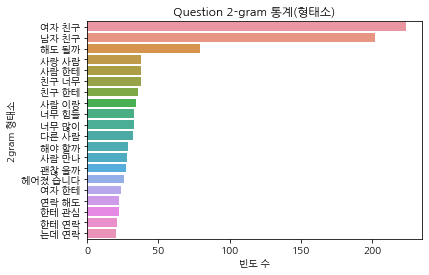

In [81]:
top_n_bigrams = get_top_ngram(q_morphs, 2)
x, y = map(list, zip(*top_n_bigrams))
ax = sns.barplot(x=y, y=x)
ax.set(xlabel='빈도 수', ylabel='2gram 형태소', title='Question 2-gram 통계(형태소)')

[Text(0.5, 0, '빈도 수'),
 Text(0, 0.5, '2gram 형태소'),
 Text(0.5, 1.0, 'Answer 2-gram 통계(형태소)')]

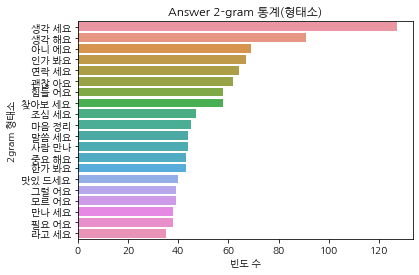

In [82]:
top_n_bigrams = get_top_ngram(a_morphs, 2)
x, y = map(list, zip(*top_n_bigrams))
ax = sns.barplot(x=y, y=x)
ax.set(xlabel='빈도 수', ylabel='2gram 형태소', title='Answer 2-gram 통계(형태소)')

[Text(0.5, 0, '빈도 수'),
 Text(0, 0.5, '3gram 형태소'),
 Text(0.5, 1.0, 'Question 3-gram 통계(형태소)')]

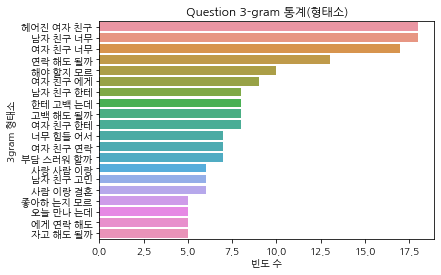

In [83]:
top_n_bigrams = get_top_ngram(q_morphs, 3)
x, y = map(list, zip(*top_n_bigrams))
ax = sns.barplot(x=y, y=x)
ax.set(xlabel='빈도 수', ylabel='3gram 형태소', title='Question 3-gram 통계(형태소)')

[Text(0.5, 0, '빈도 수'),
 Text(0, 0.5, '3gram 형태소'),
 Text(0.5, 1.0, 'Answer 3-gram 통계(형태소)')]

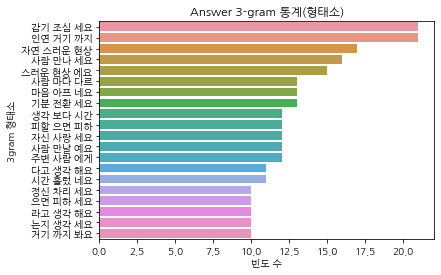

In [84]:
top_n_bigrams = get_top_ngram(a_morphs, 3)
x, y = map(list, zip(*top_n_bigrams))
ax = sns.barplot(x=y, y=x)
ax.set(xlabel='빈도 수', ylabel='3gram 형태소', title='Answer 3-gram 통계(형태소)')